# Quantifying dambos

* **Products used:** 
[gm_s2_annual](https://explorer.digitalearth.africa/gm_s2_annual)

## Description

Calculate dambo crop stats.



***
## Getting started
​
To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 


In [1]:
import datacube
import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

from matplotlib.patches import Patch
from datacube.utils import geometry
from deafrica_tools.datahandling import load_ard, mostcommon_crs
from deafrica_tools.dask import create_local_dask_cluster
from datacube.utils.cog import write_cog
from deafrica_tools.bandindices import calculate_indices
from deafrica_tools.spatial import xr_rasterize, xr_vectorize
from deafrica_tools.classification import sklearn_flatten, sklearn_unflatten

%matplotlib inline

/usr/local/lib/python3.8/dist-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/dask/dataframe/utils.py:367: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/usr/local/lib/python3.8/dist-packages/dask/dataframe/utils.py:367: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/usr/local/lib/python3.8/dist-packages/dask/dataframe/utils.py:367: FutureWarning: pandas.UInt64Index is deprecated and will be removed from pa

## Create local dask cluster

In [2]:
create_local_dask_cluster()

Client Scheduler: tcp://127.0.0.1:44735 Dashboard: /user/mickwelli@bigpond.com/proxy/8787/status,Cluster Workers: 1 Cores: 4 Memory: 28.14 GB


## Connect to datacube

In [3]:
dc = datacube.Datacube(app='dambo-analysis')

## Load classified images

/tmp/ipykernel_112/483430790.py:1: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  geotiff_crop = xr.open_rasterio('results/crop_prediction.tif')


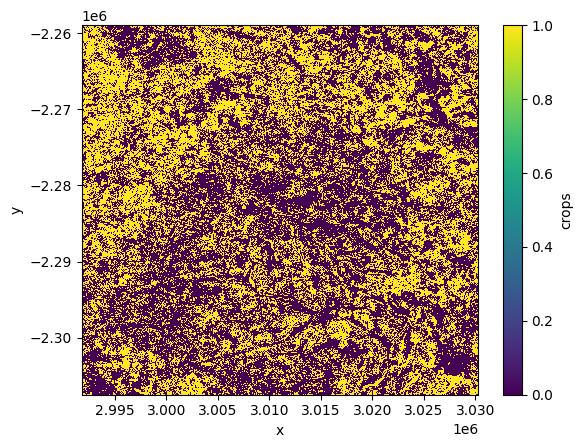

In [4]:
geotiff_crop = xr.open_rasterio('results/crop_prediction.tif')
crop_pred = geotiff_crop.to_dataset('band')
crop_pred = crop_pred.rename({1: 'crops'})

crop_pred.crops.plot()

/tmp/ipykernel_112/1441200923.py:4: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  geotiff_dambo = xr.open_rasterio('results/dambo_prediction.tif')
/usr/local/lib/python3.8/dist-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


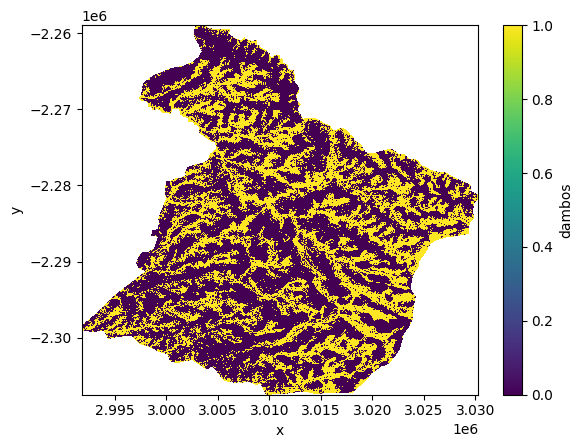

In [5]:
gdf = gpd.read_file('data/Dambo_study_area.shp')
geom = geometry.Geometry(gdf.unary_union, gdf.crs)

geotiff_dambo = xr.open_rasterio('results/dambo_prediction.tif')
dambo_pred = geotiff_dambo.to_dataset('band')
mask = xr_rasterize(gdf, dambo_pred)
dambo_pred = dambo_pred.rename({1: 'dambos'})
dambo_pred = dambo_pred.where(mask)
dambo_pred.dambos.plot()

In [6]:
crop_pred = crop_pred.assign(dambos=dambo_pred.dambos)
dambo_crops = crop_pred.assign(dambo_crops=xr.where((crop_pred.crops==1) & (dambo_pred.dambos == 1),1,np.nan))
dambo_crops = dambo_crops.assign(uplands=xr.where(dambo_pred.dambos!=1, 1, np.nan))
dambo_crops = dambo_crops.assign(upland_crops=xr.where((crop_pred.crops==1) & (dambo_pred.dambos != 1),1,np.nan))
dambo_crops = dambo_crops.where(mask)

In [7]:
write_cog(dambo_crops.to_array(), 'results/dambo_crops.tif', overwrite=True)

PosixPath('results/dambo_crops.tif')

In [8]:
dambo_crops

<xarray.Dataset>
Dimensions:       (y: 2426, x: 1928)
Coordinates:
  * y             (y) float64 -2.259e+06 -2.259e+06 ... -2.307e+06 -2.307e+06
  * x             (x) float64 2.992e+06 2.992e+06 ... 3.03e+06 3.03e+06
Data variables:
    crops         (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    dambos        (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    dambo_crops   (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    uplands       (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    upland_crops  (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    transform:      (20.0, 0.0, 2991760.0, 0.0, -20.0, -2258960.0)
    crs:            +init=epsg:6933
    res:            (20.0, 20.0)
    is_tiled:       1
    nodatavals:     (nan,)
    scales:         (1.0,)
    offsets:        (0.0,)
    AREA_OR_POINT:  Area

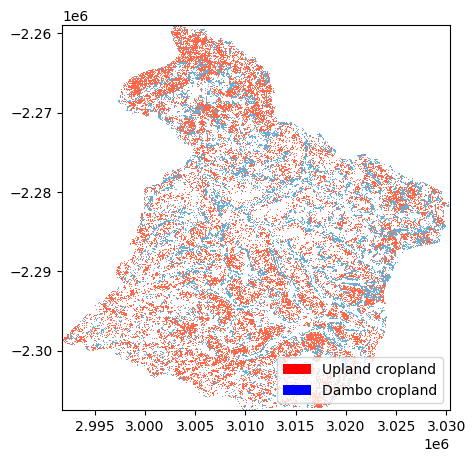

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))


dambo_crops.upland_crops.plot(
    ax=ax, cmap="Reds", add_colorbar=False, add_labels=False
)
dambo_crops.dambo_crops.plot(
    ax=ax, cmap="Blues", add_colorbar=False, add_labels=False
)
ax.legend(
    [
        Patch(facecolor='Red'),
        Patch(facecolor='Blue'),
    ],
    ["Upland cropland", "Dambo cropland"],
    loc="lower right")

plt.show();

In [10]:
m2_per_ha = 10000
m2_per_pixel = 20 ** 2

dambo_count = dambo_crops.dambos.sum().values * m2_per_pixel / m2_per_ha
upland_count = dambo_crops.uplands.sum().values * m2_per_pixel / m2_per_ha
crops_count = dambo_crops.crops.sum().values * m2_per_pixel / m2_per_ha
dambo_crops_count = dambo_crops.dambo_crops.sum().values* m2_per_pixel / m2_per_ha
upland_crops_count = dambo_crops.upland_crops.sum().values* m2_per_pixel / m2_per_ha

counts_total = {
          'Dambo area': dambo_count,
          'Upland area': upland_count
          }

df_total = pd.DataFrame(counts_total, index=['Area (Ha)']).transpose()

percentage = []
for i in range(df_total.shape[0]):
    pct = (df_total['Area (Ha)'][i]) / (df_total['Area (Ha)'].sum()) * 100
    percentage.append(round(pct,2))
df_total['Percentage'] = percentage

counts_cropped = {
          'Dambo cropped': dambo_crops_count,
          'Upland cropped': upland_crops_count
          }

df_cropped = pd.DataFrame(counts_cropped, index=['Area (Ha)']).transpose()

percentage = []
for i in range(df_cropped.shape[0]):
    pct = (df_cropped['Area (Ha)'][i]) / (df_cropped['Area (Ha)'].sum()) * 100
    percentage.append(round(pct,2))
df_cropped['Percentage'] = percentage

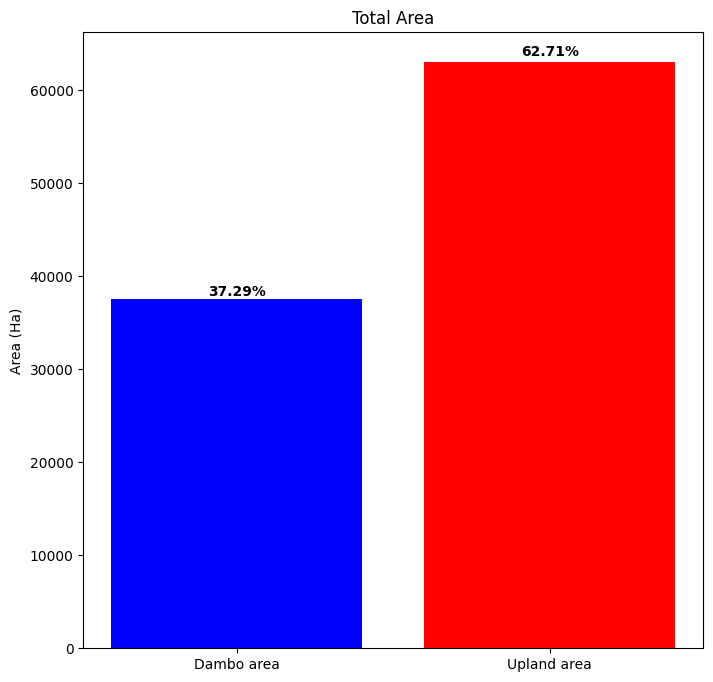

In [11]:
plt.figure(figsize=(8,8))
colors_list = ['Blue', 'Red']
graph = plt.bar(df_total.index,df_total['Area (Ha)'], color = colors_list)
plt.ylabel('Area (Ha)')
plt.title('Total Area')
 
i = 0
for p in graph:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    plt.text(x+width/2,
             y+height*1.01,
             str(df_total.Percentage[i])+'%',
             ha='center',
             weight='bold')
    i+=1
plt.show()

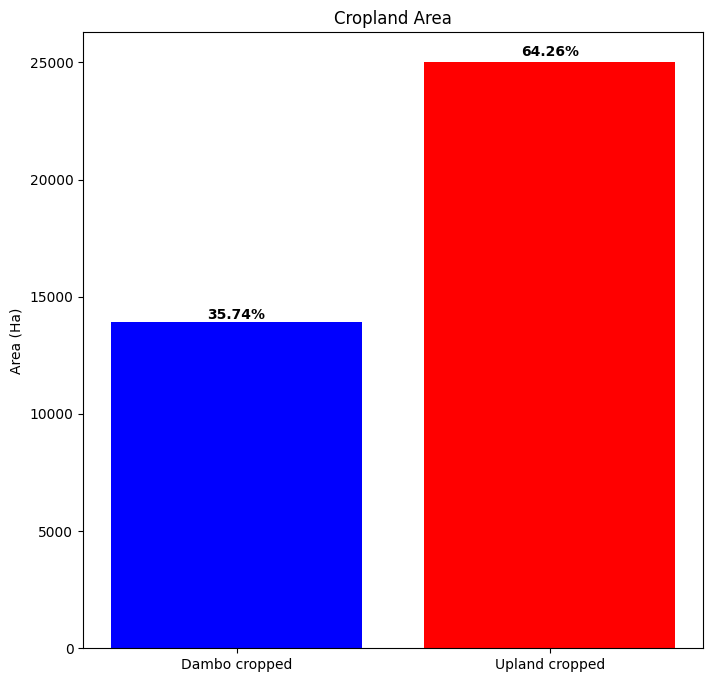

In [12]:
plt.figure(figsize=(8,8))
colors_list = ['Blue', 'Red']
graph = plt.bar(df_cropped.index,df_cropped['Area (Ha)'], color = colors_list)
plt.ylabel('Area (Ha)')
plt.title('Cropland Area')
 
i = 0
for p in graph:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    plt.text(x+width/2,
             y+height*1.01,
             str(df_cropped.Percentage[i])+'%',
             ha='center',
             weight='bold')
    i+=1
plt.show()

In [13]:
gdf = gpd.read_file('data/Dambo_study_area.shp')
geom = geometry.Geometry(gdf.unary_union, gdf.crs)
query = {
    'geopolygon': geom,
    'time': ('2018-01-01','2021-12-31'),
    'measurements': ['red', 'green', 'blue', 'nir'],
    'resolution': (-60, 60),
    'output_crs': 'epsg:6933',
    'dask_chunks' : {'time':1, 'x':1000,'y':1000},
}


s2_ds = load_ard(dc=dc,
              products=['s2_l2a'],
              min_gooddata=0.8,
              **query)
    

/home/jovyan/.local/lib/python3.8/site-packages/deafrica_tools/datahandling.py:238: UserWarning: Setting 'min_gooddata' percentage to > 0.0 will cause dask arrays to compute when loading pixel-quality data to calculate 'good pixel' percentage. This can slow the return of your dataset.
  warnings.warn(


Using pixel quality parameters for Sentinel 2
Finding datasets
    s2_l2a
Counting good quality pixels for each time step
Filtering to 753 out of 986 time steps with at least 80.0% good quality pixels
Applying pixel quality/cloud mask
Returning 753 time steps as a dask array


In [14]:
s2_ndvi = calculate_indices(s2_ds, index=['NDVI'], drop=True, collection='s2')

Dropping bands ['red', 'green', 'blue', 'nir']


/tmp/ipykernel_112/818993059.py:1: DeprecationWarning: `collection` was deprecated in version 0.1.7. Use `satelite_mission` instead.
  s2_ndvi = calculate_indices(s2_ds, index=['NDVI'], drop=True, collection='s2')


In [15]:
s2_ndvi_dambos = s2_ndvi.where(dambo_crops.dambos==1) 

/usr/local/lib/python3.8/dist-packages/xarray/core/indexing.py:1228: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


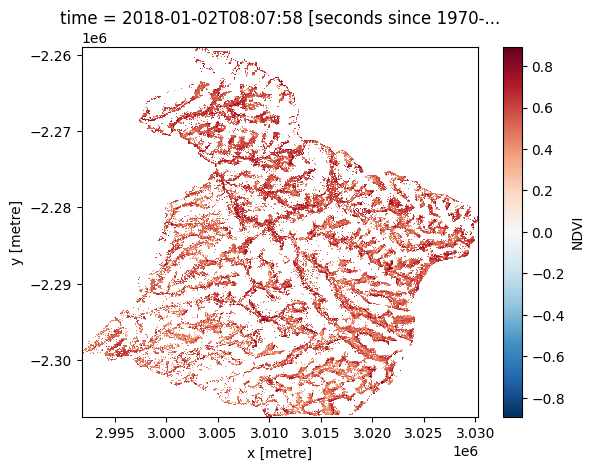

In [16]:
s2_ndvi_dambos.NDVI[0].plot()

In [17]:
s2_ndvi_uplands = s2_ndvi.where(dambo_crops.uplands==1) 

/usr/local/lib/python3.8/dist-packages/xarray/core/indexing.py:1228: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


In [18]:
s2_ndvi_uplands

<xarray.Dataset>
Dimensions:      (time: 753, y: 809, x: 642)
Coordinates:
  * y            (y) float64 -2.259e+06 -2.259e+06 ... -2.307e+06 -2.307e+06
  * x            (x) float64 2.992e+06 2.992e+06 2.992e+06 ... 3.03e+06 3.03e+06
  * time         (time) datetime64[ns] 2018-01-02T08:07:58 ... 2021-12-27T08:...
    spatial_ref  int32 6933
Data variables:
    NDVI         (time, y, x) float32 dask.array<chunksize=(1, 809, 642), meta=np.ndarray>
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref

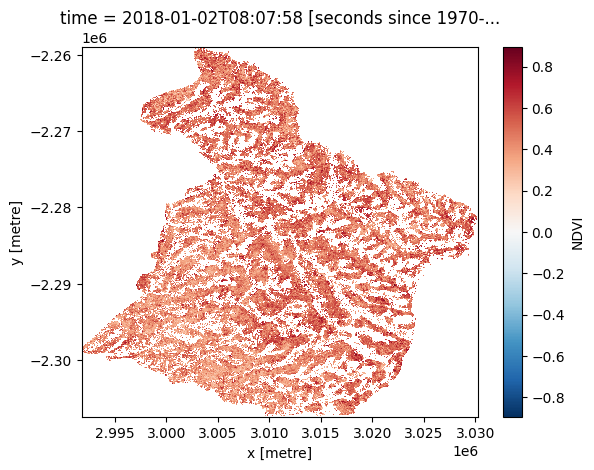

In [19]:
s2_ndvi_uplands.NDVI[0].plot()

## Resample to timeseries

Takes a long time to run

In [20]:
ndvi_mean_dambo = s2_ndvi_dambos.resample(time='3M').mean().NDVI.mean(['x','y']).compute()
ndvi_std_dambo = s2_ndvi_dambos.resample(time='3M').mean().NDVI.std(['x','y']).compute()
ndvi_mean_upland = s2_ndvi_uplands.resample(time='3M').mean().NDVI.mean(['x','y']).compute()
ndvi_std_upland = s2_ndvi_uplands.resample(time='3M').mean().NDVI.std(['x','y']).compute()

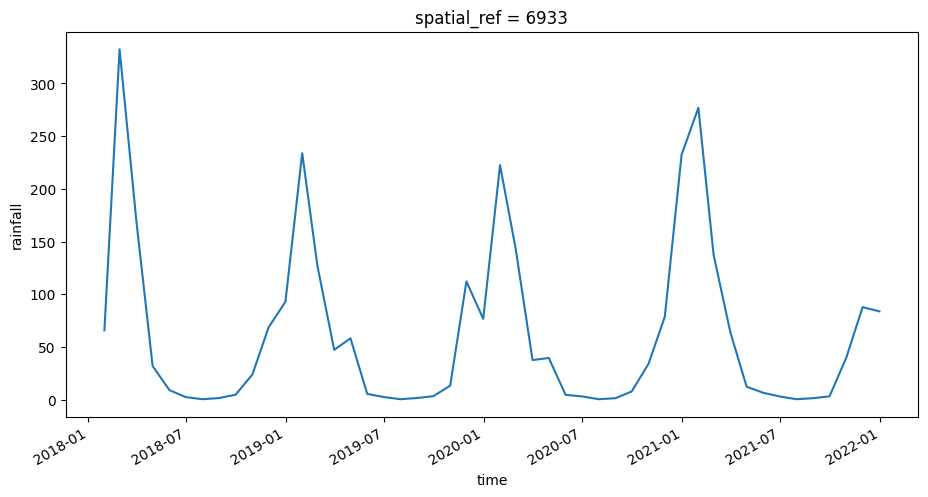

In [21]:
ds_rf_month = dc.load(product='rainfall_chirps_monthly',
                time=('2018-01-01', '2021-12-31'),
                geopolygon = geom,
                resolution=(-5000, 5000),
                output_crs='epsg:6933')

ds_rf_month.resample(time='1M').mean().rainfall.mean(['x','y']).plot(figsize=(11, 5))

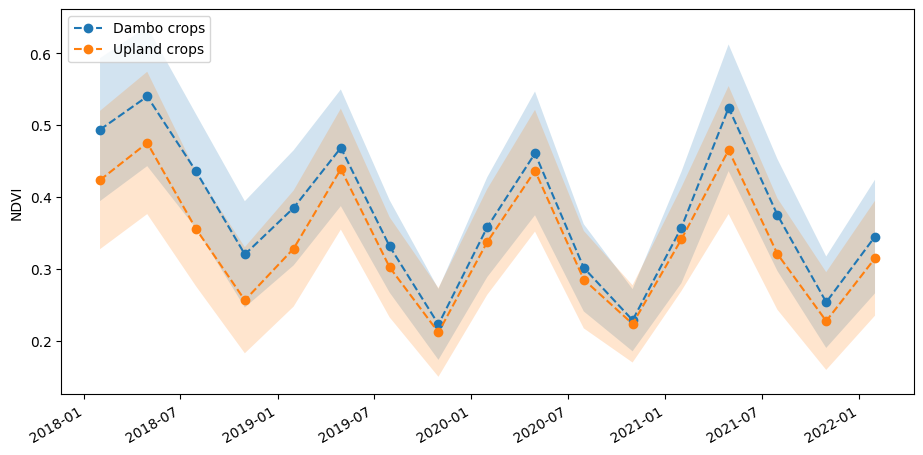

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(11, 5))
ndvi_mean_dambo.plot(ax=ax, label='Dambo crops', linestyle='dashed', marker='o')
ndvi_mean_upland.plot(ax=ax, label='Upland crops', linestyle='dashed', marker='o')
ax.fill_between(
    ndvi_mean_dambo.time,
    ndvi_mean_dambo-ndvi_std_dambo,
    ndvi_mean_dambo+ndvi_std_dambo,
    alpha=0.2,
)
ax.fill_between(
    ndvi_mean_upland.time,
    ndvi_mean_upland-ndvi_std_upland,
    ndvi_mean_upland+ndvi_std_upland,
    alpha=0.2,
)
plt.legend(loc="upper left")
plt.title("")
plt.xlabel("");

In [23]:
ds_st_month = load_ard(
                dc=dc,
                products=['ls9_st', 'ls8_st'],
               time=('2018-01-01', '2021-12-31'),
                geopolygon = geom,
                resolution=(-60, 60),
                measurements = ['surface_temperature', 'surface_temperature_quality'],
                output_crs='EPSG:6933',
                dask_chunks = {'time':1, 'x':1000,'y':1000})

ds_st_month

Using pixel quality parameters for USGS Collection 2
Finding datasets
    ls9_st
    ls8_st
Applying pixel quality/cloud mask
Re-scaling Landsat C2 data
Returning 356 time steps as a dask array


<xarray.Dataset>
Dimensions:                      (time: 356, y: 809, x: 643)
Coordinates:
  * time                         (time) datetime64[ns] 2018-01-04T07:53:53.16...
  * y                            (y) float64 -2.259e+06 ... -2.307e+06
  * x                            (x) float64 2.992e+06 2.992e+06 ... 3.03e+06
    spatial_ref                  int32 6933
Data variables:
    surface_temperature          (time, y, x) float32 dask.array<chunksize=(1, 809, 643), meta=np.ndarray>
    surface_temperature_quality  (time, y, x) float32 dask.array<chunksize=(1, 809, 643), meta=np.ndarray>
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref

In [24]:
ds_st_dambos = ds_st_month.where(dambo_crops.dambos==1)
ds_st_uplands = ds_st_month.where(dambo_crops.uplands==1)

/usr/local/lib/python3.8/dist-packages/xarray/core/indexing.py:1228: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/usr/local/lib/python3.8/dist-packages/xarray/core/indexing.py:1228: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


In [25]:
ds_st_dambos

<xarray.Dataset>
Dimensions:                      (time: 356, y: 809, x: 642)
Coordinates:
  * y                            (y) float64 -2.259e+06 ... -2.307e+06
  * x                            (x) float64 2.992e+06 2.992e+06 ... 3.03e+06
  * time                         (time) datetime64[ns] 2018-01-04T07:53:53.16...
    spatial_ref                  int32 6933
Data variables:
    surface_temperature          (time, y, x) float32 dask.array<chunksize=(1, 809, 642), meta=np.ndarray>
    surface_temperature_quality  (time, y, x) float32 dask.array<chunksize=(1, 809, 642), meta=np.ndarray>
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref

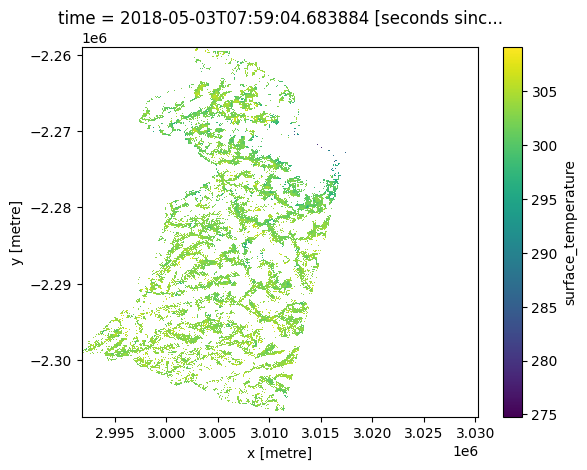

In [26]:
ds_st_dambos.surface_temperature[25].plot()

In [27]:
st_mean_dambo = ds_st_dambos.resample(time='1M').mean().surface_temperature.mean(['x','y']).compute()
st_std_dambo = ds_st_dambos.resample(time='1M').mean().surface_temperature.std(['x','y']).compute()

st_mean_uplands = ds_st_uplands.resample(time='1M').mean().surface_temperature.mean(['x','y']).compute()
st_std_uplands = ds_st_uplands.resample(time='1M').mean().surface_temperature.std(['x','y']).compute()

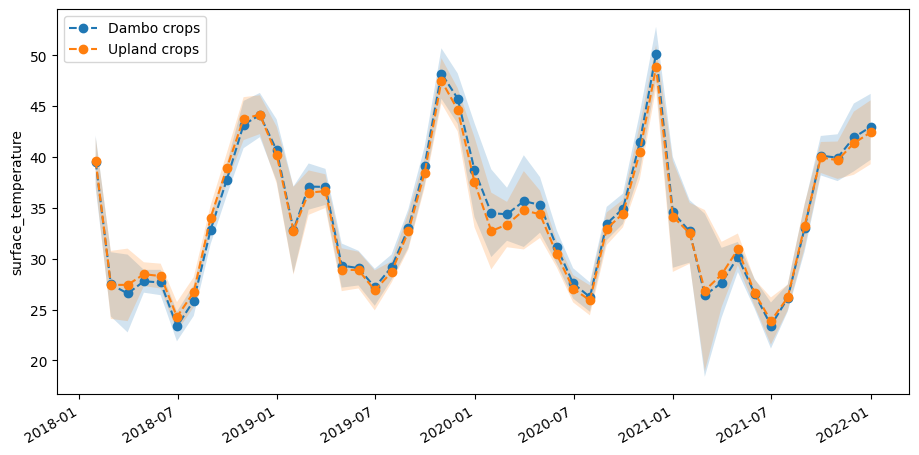

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(11, 5))
(st_mean_dambo-273.15).plot(ax=ax, label='Dambo crops', linestyle='dashed', marker='o')
(st_mean_uplands-273.15).plot(ax=ax, label='Upland crops', linestyle='dashed', marker='o')
ax.fill_between(
    st_mean_dambo.time,
    st_mean_dambo-st_std_dambo-273.15 ,
    st_mean_dambo+st_std_dambo-273.15 ,
    alpha=0.2,
)
ax.fill_between(
    st_std_uplands.time,
    st_mean_uplands-st_std_uplands-273.15,
    st_mean_uplands+st_std_uplands-273.15,
    alpha=0.2,
)
plt.legend(loc="upper left")
plt.title("")
plt.xlabel("");

In [30]:
from deafrica_tools.load_isda import load_isda
from urllib.parse import urlparse
import boto3
from pystac import stac_io, Catalog

#this function allows us to directly query the data on s3
def my_read_method(uri):
    parsed = urlparse(uri)
    if parsed.scheme == 's3':
        bucket = parsed.netloc
        key = parsed.path[1:]
        s3 = boto3.resource('s3')
        obj = s3.Object(bucket, key)
        return obj.get()['Body'].read().decode('utf-8')
    else:
        return stac_io.default_read_text_method(uri)
    
stac_io.read_text_method = my_read_method

catalog = Catalog.from_file("https://isdasoil.s3.amazonaws.com/catalog.json")

assets = {}

for root, catalogs, items in catalog.walk():
    for item in items:
        str(f"Type: {item.get_parent().title}")
        # save all items to a dictionary as we go along
        assets[item.id] = item
        for asset in item.assets.values():
            if asset.roles == ['data']:
                str(f"Title: {asset.title}")
                str(f"Description: {asset.description}")
                str(f"URL: {asset.href}")
                str("------------")

In [44]:
buffer = 0.1

tc_ds = load_isda("carbon_total", (-18.22 - buffer, -18.22 + buffer), (31.22 - buffer, 31.22 + buffer))
tc_ds[list(tc_ds.keys())[0]]

/usr/local/lib/python3.8/dist-packages/rioxarray/_io.py:314: NodataShadowWarning: The dataset's nodata attribute is shadowing the alpha band. All masks will be determined by the nodata attribute
  out = riods.read(band_key, window=window, masked=self.masked)


<xarray.DataArray 'Carbon, total, predicted mean at 0-20 cm depth' (y: 782,
                                                                    x: 743)>
array([[31., 31., 31., ..., 31., 32., 32.],
       [31., 31., 32., ..., 31., 32., 32.],
       [31., 31., 33., ..., 30., 32., 32.],
       ...,
       [22., 23., 23., ..., 24., 25., 24.],
       [24., 23., 24., ..., 24., 25., 24.],
       [23., 24., 24., ..., 24., 24., 24.]], dtype=float32)
Coordinates:
  * x            (x) float64 3.464e+06 3.464e+06 ... 3.487e+06 3.487e+06
  * y            (y) float64 -2.052e+06 -2.052e+06 ... -2.075e+06 -2.075e+06
    spatial_ref  int64 0
    band         <U9 'band_data'

In [56]:
tc_ds.rio.write_crs(6933, inplace=True)

<xarray.Dataset>
Dimensions:                                              (x: 743, y: 782)
Coordinates:
  * x                                                    (x) float64 3.464e+0...
  * y                                                    (y) float64 -2.052e+...
    band                                                 <U9 'band_data'
    spatial_ref                                          int64 0
Data variables:
    Carbon, total, predicted mean at 0-20 cm depth       (y, x) float32 31.0 ...
    Carbon, total, predicted mean at 20-50 cm depth      (y, x) float32 27.0 ...
    Carbon, total, standard deviation at 0-20 cm depth   (y, x) float32 4.0 ....
    Carbon, total, standard deviation at 20-50 cm depth  (y, x) float32 3.0 ....

In [60]:
dambo_crops

<xarray.Dataset>
Dimensions:       (y: 2426, x: 1928)
Coordinates:
  * y             (y) float64 -2.259e+06 -2.259e+06 ... -2.307e+06 -2.307e+06
  * x             (x) float64 2.992e+06 2.992e+06 ... 3.03e+06 3.03e+06
Data variables:
    crops         (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    dambos        (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    dambo_crops   (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    uplands       (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    upland_crops  (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    transform:      (20.0, 0.0, 2991760.0, 0.0, -20.0, -2258960.0)
    crs:            +init=epsg:6933
    res:            (20.0, 20.0)
    is_tiled:       1
    nodatavals:     (nan,)
    scales:         (1.0,)
    offsets:        (0.0,)
    AREA_OR_POINT:  Area

In [62]:
tc_ds_dambos = tc_ds.where(dambo_crops.dambos==1)
tc_ds_dambos

<xarray.Dataset>
Dimensions:                                              (y: 0, x: 0)
Coordinates:
  * x                                                    (x) float64 
  * y                                                    (y) float64 
    band                                                 <U9 'band_data'
    spatial_ref                                          int64 0
Data variables:
    Carbon, total, predicted mean at 0-20 cm depth       (y, x) float32 
    Carbon, total, predicted mean at 20-50 cm depth      (y, x) float32 
    Carbon, total, standard deviation at 0-20 cm depth   (y, x) float32 
    Carbon, total, standard deviation at 20-50 cm depth  (y, x) float32